<b>Google Colab</b> <a href="https://colab.research.google.com/github/kirillzyusko/deeplearning/blob/master/5/lab.ipynb">link</a>

Authorize google + kaggle

In [1]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Download 100%.


Be sure, that we authorized and have an access to kaggle

In [6]:
%ls /content/.kaggle/

kaggle.json*


# **Part 1: Download dataset, extract, split, check data distribution**

In [8]:
!mkdir ~/.kaggle
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle competitions download  -c dogs-vs-cats -p /content/kaggle/dogscats

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 98% 532M/543M [00:04<00:00, 97.2MB/s]
100% 543M/543M [00:04<00:00, 138MB/s] 
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 83.9MB/s]
100% 271M/271M [00:25<00:00, 18.8MB/s]
100% 271M/271M [00:25<00:00, 11.3MB/s]


Extract .zip


In [0]:
!unzip kaggle/dogscats/train.zip -d train
!unzip kaggle/dogscats/test1.zip -d test

In [22]:
%ls

adc.json  kaggle/  sample_data/  test/  train/


In [30]:
import pandas as pd
import os

TRAIN_PATH = './train/train'
TEST_PATH = './test/test1'

filenames = os.listdir(TRAIN_PATH)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

df.head()

,filename,category
0,dog.7949.jpg,1
1,cat.8664.jpg,0
2,dog.8276.jpg,1
3,dog.5957.jpg,1
4,dog.9508.jpg,1


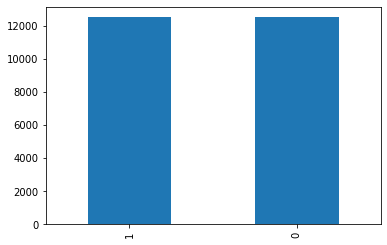

In [31]:
df['category'].value_counts().plot.bar()

Train/Dev split


In [0]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(df, test_size=0.20, random_state=42)

Check data distribution

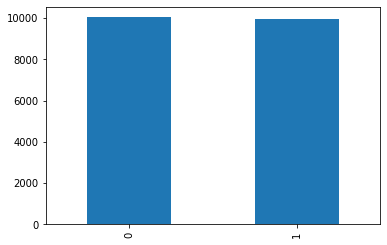

In [33]:
train['category'].value_counts().plot.bar()

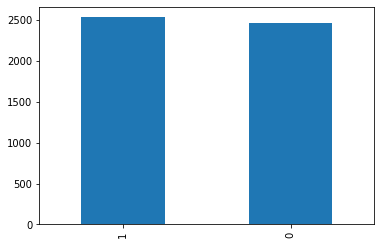

In [34]:
val['category'].value_counts().plot.bar()

Use `ImageDataGenerator` in order to reduce data memory consumption (just with rescaling for improving speed of learning)

In [0]:
from keras.preprocessing.image import ImageDataGenerator, load_img

# train
train_datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32  # since Andrew Ng told, that better use 2^n

train_generator = train_datagen.flow_from_dataframe(
    train, 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

# validation
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    val, 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

# TODO: implement test set preparation 

# **Part 2: DNN architecture**

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 classes: dog and cat

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

model.summary()

In [0]:
model.fit(X_train, np.array(pd.get_dummies(y_train)),
              epochs=1000,
              verbose=1,
              validation_data=(X_test, np.array(pd.get_dummies(y_test))))